# MultiClass Classification & Transfer Learning


This notebook contains an application of Multiclass Classification of images, using the concept of Transfer Learning.

### Transfer Learning:
Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task. We use an existing model that's trained on far more data, and use the features that that model learned, to help with our predictions.
We can lock the layers of the pretrained model instead of retraining them on our data, and have those just extract the features from our data using the convolutions that they've already learned. We will then add our own DNN at the bottom of these, which we can retrain to our data.

### Dataset Used:
**Fruits 360** - A dataset with 90483 images of 131 fruits and vegetables

Link: https://www.kaggle.com/moltean/fruits/download

### Pre-trained Model Used:
We use the **Inception Model** which has been pre-trained on a dataset from ImageNet, which has 1.4 million images in a 1000 different classes.

Link: https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [1]:
# Import libraries

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model  
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

Using TensorFlow backend.


2.2.0


* Load the Inception Model Weights
* Freeze all the layers of the Inception Model to make them untrainable 
* Select an appropriate layer from the pre-trained model as the last layer, after which we will stack it upon our own DNN

In [2]:
local_weights_file = 'model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (100, 100, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

We now stack the pre-trained layers on top of our own DNN. The final layer will be a softmax layers of 131 units (for each of the 131 classes).

In [3]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final softmax layer for classification
x = layers.Dense(131, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 49, 49, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [4]:
# Define a Callback class that stops training once accuracy reaches 99%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()

#### Load training and validation data from directory

In [5]:
# Define our example directories and files
base_dir = 'archive/fruits-360'

train_dir = os.path.join( base_dir, 'Training')
validation_dir = os.path.join( base_dir, 'Test')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'categorical', 
                                                    target_size = (100, 100))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical', 
                                                          target_size = (100, 100))

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


### Visualizing Random Training Images

Re-run the below cell to generate new random set of fruit images (from training dataset).

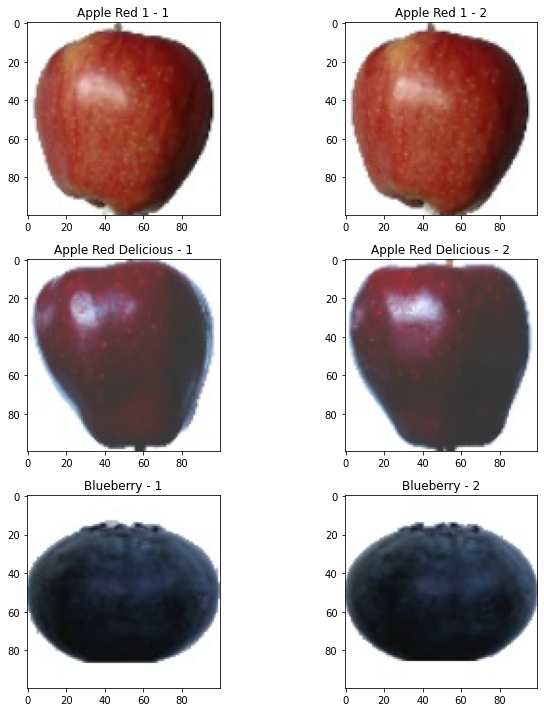

In [6]:
import random
fruits = [os.listdir(train_dir)[x] for x in random.sample(range(len(train_dir)),3)]
f, ax = plt.subplots(3,2,figsize=(10,10))
for row,fruit in enumerate(fruits):
    fruit_dir = os.path.join(train_dir,fruit)
    imgpath1, imgpath2 = [os.listdir(fruit_dir)[i] for i in random.sample(range(len(fruit_dir)),2)]

    img1 = mpimg.imread(os.path.join(fruit_dir,imgpath1))
    img2 = mpimg.imread(os.path.join(fruit_dir,imgpath2))
    
    ax[row,0].imshow(img1)
    ax[row,0].set_title(fruit + ' - ' + str(1))
    ax[row,1].imshow(img2)
    ax[row,1].set_title(fruit + ' - ' + str(2))

plt.tight_layout()

### Model Fitting

In [7]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 50,
            validation_steps = 50,
            verbose = 2,
#             callbacks=[callback]
            )

Epoch 1/50
100/100 - 5s - loss: 2.8242 - accuracy: 0.4280 - val_loss: 1.7658 - val_accuracy: 0.6200
Epoch 2/50
100/100 - 4s - loss: 0.9841 - accuracy: 0.7810 - val_loss: 0.8801 - val_accuracy: 0.8110
Epoch 3/50
100/100 - 9s - loss: 0.4282 - accuracy: 0.9040 - val_loss: 0.6112 - val_accuracy: 0.8570
Epoch 4/50
100/100 - 10s - loss: 0.2382 - accuracy: 0.9420 - val_loss: 0.5206 - val_accuracy: 0.8780
Epoch 5/50
100/100 - 10s - loss: 0.1579 - accuracy: 0.9605 - val_loss: 0.4716 - val_accuracy: 0.8700
Epoch 6/50
100/100 - 10s - loss: 0.1239 - accuracy: 0.9660 - val_loss: 0.4230 - val_accuracy: 0.8910
Epoch 7/50
100/100 - 10s - loss: 0.0875 - accuracy: 0.9740 - val_loss: 0.3428 - val_accuracy: 0.9190
Epoch 8/50
100/100 - 7s - loss: 0.0646 - accuracy: 0.9840 - val_loss: 0.3124 - val_accuracy: 0.9120
Epoch 9/50
100/100 - 3s - loss: 0.0556 - accuracy: 0.9865 - val_loss: 0.3348 - val_accuracy: 0.9210
Epoch 10/50
100/100 - 3s - loss: 0.0499 - accuracy: 0.9860 - val_loss: 0.2854 - val_accuracy: 0.

### Results

The results show that our model has achieved near 100% training accuracy, and ~95.5% test accuracy, which is quite good!

The below graphs of Training vs Validation accuracy, and Training vs Validation loss help us in visualizing the same.

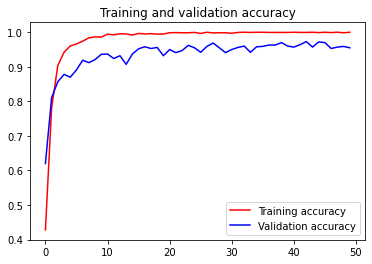

<Figure size 432x288 with 0 Axes>

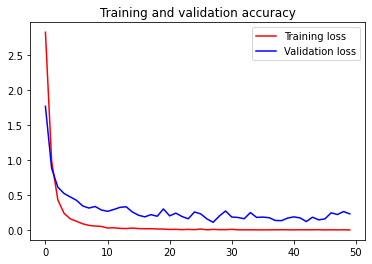

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()